### Dependency

In [8]:
import numpy as np
import pickle
import torch

import pandas as pd
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import seaborn as sns

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Load claims and zip2fips data

In [3]:
data_path = r"D:\OneDrive - University of Edinburgh\paper\Spatio-temporal RSV\TAP-RSV 2\RSV\data"
#../data/claim.csv
disease_data = pd.read_csv(os.path.join(data_path,"claim.csv"))
# zip2fips = json.load(open("zip2fips.json", 'r'))
zip2fips_data = pd.read_csv(os.path.join(data_path,"zip2fips.csv"))

In [4]:
zip2fips = {}
for k, v in tqdm(zip2fips_data[["zipcode", "FIPS"]].values):
    if v == v:
        zip2fips[int(k)] = int(v)

100%|██████████| 41877/41877 [00:00<00:00, 1613226.44it/s]


In [5]:
disease_data.head()

,Unnamed: 0,date,zip,n_visits,Adenovirus,Asthma,Bronchiolitis,COVID,Cold,Coronavirus,...,Hypoxia,Parainfluenza,RSV,Respiratory distress,Respiratory failure,Rhinitis,Rhinovirus,Status Asthmaticus,URI,Viral pneumonia
0,0,2017-12-30,631,2,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,1,2017-12-30,637,4,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,3,0
2,2,2017-12-30,656,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
3,3,2017-12-30,716,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
4,4,2017-12-30,717,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
disease_data.columns

Index(['Unnamed: 0', 'date', 'zip', 'n_visits', 'Adenovirus', 'Asthma',
       'Bronchiolitis', 'COVID', 'Cold', 'Coronavirus', 'Enterovirus', 'HMPV',
       'Hypoxemia', 'Hypoxia', 'Parainfluenza', 'RSV', 'Respiratory distress',
       'Respiratory failure', 'Rhinitis', 'Rhinovirus', 'Status Asthmaticus',
       'URI', 'Viral pneumonia'],
      dtype='object')

### get the (county, date, 19 diseases) b_mtx

In [7]:
disease_category = disease_data.columns[4:]
date_map = {item: idx for idx, item in enumerate(disease_data.date.unique())}
zip_map = {item: idx for idx, item in enumerate(disease_data.zip.unique())}
fips_concern = np.unique([zip2fips.get(zipcode, -1) for zipcode in list(zip_map.keys())]).tolist()
fips_concern.remove(-1)
fips_map = {item: idx for idx, item in enumerate(fips_concern)}

b_mtx = np.zeros((len(fips_map), len(date_map), len(disease_category)))
print (b_mtx.shape)

(3150, 1848, 19)


In [9]:
for line in tqdm(disease_data.values):
    tmp_fips = zip2fips.get(line[2], -1)
    if tmp_fips == -1: continue
    
    for j in range(len(disease_category)):
        b_mtx[fips_map[tmp_fips], date_map[line[1]], j] = line[4 + j]

100%|██████████| 12325169/12325169 [00:48<00:00, 254439.71it/s]


In [10]:
fips_standard = pickle.load(open(os.path.join(data_path, "fips.pkl"), "rb"))
county = pickle.load(open(os.path.join(data_path, "county.pkl"), "rb"))
feat_name_HOIST = pickle.load(open(os.path.join(data_path, "feat_name.pkl"), "rb"))

In [11]:
# static feature ranges (it is ok, non-overlap with our prediction window)
min(feat_name_HOIST['date']), max(feat_name_HOIST['date'])

('2020-08-01', '2022-05-01')

In [12]:
# get the intersection fips
fips_new_idx = []
int_fips_map = list(map(int, fips_map.keys()))

for idx, fips in enumerate(fips_standard):
    if fips in int_fips_map:
        fips_new_idx.append(int_fips_map.index(fips))
    else:
        fips_new_idx.append(0)
    
# the fips (dim 1) of this bron matchs with Junyi's 2334 fips
bron = b_mtx[fips_new_idx]
print (bron.shape)

# aggregate the date into weeks
bron = np.diff(np.concatenate([np.zeros((bron.shape[0], 1, bron.shape[2])), np.cumsum(bron, 1)], 1)[:, ::7], axis=1)
weeks = list(date_map.keys())[::7]


(2334, 1848, 19)


### final processed data

In [13]:
print (len(weeks))
print (bron.shape)

264
(2334, 264, 19)


### tensor factorization tool

In [14]:
def optimize(A, B, D, reg=1e-6):
    u = np.linalg.solve(A + reg * D, B)
    return u

def initialize(T, R, device):
    return *[np.random.random((I, R)) for I in T.shape], np.eye(R)

def NTF_3d(T, A1, A2, A3, D, iteration=200, reg=1e-3, verbose=True):
    interval = iteration // 10
    for i in range(iteration):
        A1 = optimize((A2.T@A2) * (A3.T@A3), np.einsum('ijk,jr,kr->ri',T,A2,A3, optimize=True), D).T
#         A1 = torch.clip(A1, min=0)
#         A1 -= A1.max(1)[0].reshape(-1, 1) * reg * (A1 == np.abs(A1)) * torch.ones_like(A1)
        A1 = np.clip(A1, a_min=1e-8, a_max=2)
        
        A2 = optimize((A1.T@A1) * (A3.T@A3), np.einsum('ijk,ir,kr->rj',T,A1,A3, optimize=True), D).T
        A2 = np.clip(A2, a_min=1e-8, a_max=2)
        
        A3 = optimize((A2.T@A2) * (A1.T@A1), np.einsum('ijk,ir,jr->rk',T,A1,A2, optimize=True), D).T
        A3 = np.clip(A3,  a_min=1e-8, a_max=2)
        A3 -= A3.max(1)[0].reshape(-1, 1) * reg * (A3 == np.abs(A3)) * np.ones_like(A3)
        A3 = np.clip(A3, a_min=1e-8, a_max=2)
            
        if verbose:
            if i % interval == interval - 1:
                rec = np.einsum('ir,jr,kr->ijk',A1,A2,A3, optimize=True)
                loss = (np.linalg.norm(rec - T) / np.linalg.norm(T))**2
                print ('{}/{}'.format(i, iteration), 'fitness loss:', loss.item())
        
        scale1 = (A1**2).sum(0) ** 0.5
        scale2 = (A2**2).sum(0) ** 0.5
        scale3 = (A3**2).sum(0) ** 0.5
        scale = (scale1 * scale2 * scale3) ** (1/3)

        A1 = A1 / scale1.reshape(1, -1) * scale.reshape(1, -1)
        A2 = A2 / scale2.reshape(1, -1) * scale.reshape(1, -1)
        A3 = A3 / scale3.reshape(1, -1) * scale.reshape(1, -1)
            
    result = [A1, A2, A3]
    return result

### conduct sparse NTF

In [15]:
#####################################
# select the training period and scale by county pediatric population
rate = bron[:, :weeks.index("2022-11-26"), :] / county[:, 1].reshape(-1, 1, 1)
######################################

In [16]:
np.random.seed(300)
R = 8
result = NTF_3d(rate, *initialize(rate, R=R, device='cpu'), reg=1e-1, iteration=100)

9/100 fitness loss: 0.26071283646260396
19/100 fitness loss: 0.2532090095681406
29/100 fitness loss: 0.2530748095590598
39/100 fitness loss: 0.2530605612014997
49/100 fitness loss: 0.25306170826050783
59/100 fitness loss: 0.25306267282604156
69/100 fitness loss: 0.253062962565311
79/100 fitness loss: 0.25306298637610936
89/100 fitness loss: 0.2530629598111741
99/100 fitness loss: 0.2530629365306347


### plot 8 patterns

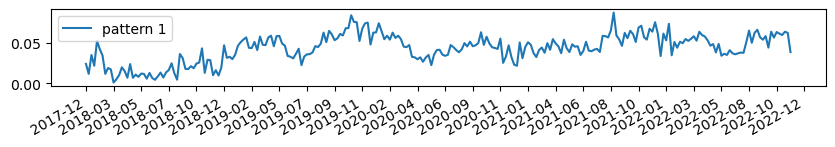

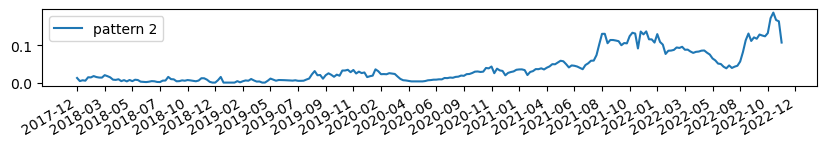

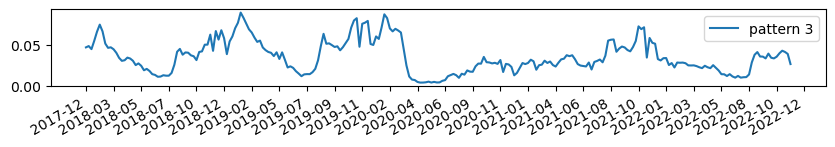

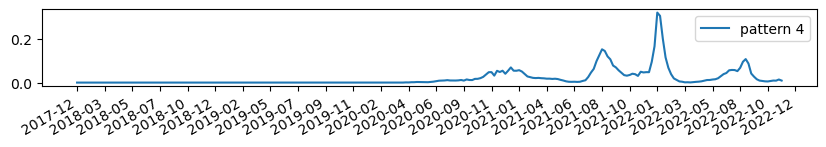

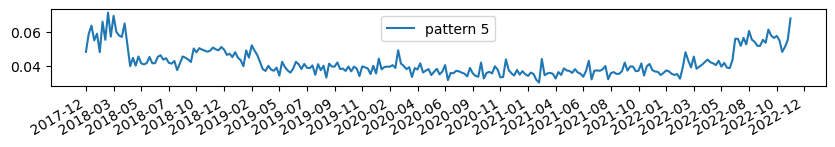

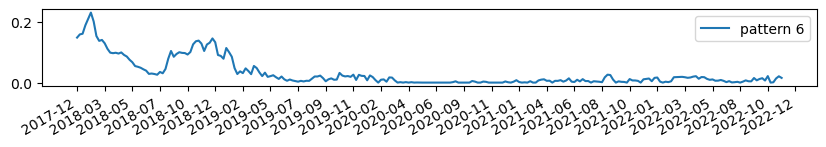

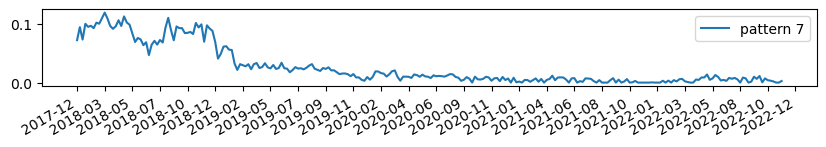

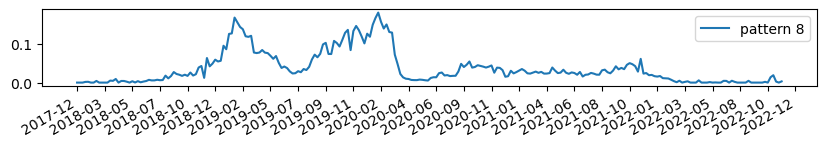

In [17]:
for i in range(R):
    plt.figure(figsize=(10, 1))
    plt.plot(result[1][:, i], label=f"pattern {i+1}")
    all_date = [item[:-3] for item in list(date_map.keys())[::7]]
    plt.xticks(np.arange(len(all_date))[::10], all_date[::10], rotation=30, fontsize=10, ha="right")
    plt.legend()

### each column in the figure is the disease representation

In [18]:
# normalize the patterns and let each disease sum up to 1
result[2] = result[2] / result[2].sum(1).reshape(-1, 1)

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(4,8), dpi=300)
plt.imshow((result[2]))
plt.yticks(np.arange(19), ['Adenovirus', 'Asthma', 'Bronchiolitis', 'COVID', 'Cold', 'Coronavirus',
       'Enterovirus', 'HMPV', 'Hypoxemia', 'Hypoxia', 'Parainfluenza', 'RSV',
       'Respiratory distress', 'Respiratory failure', 'Rhinitis', 'Rhinovirus',
       'Status Asthmaticus', 'URI', 'Viral pneumonia'], fontsize=16, ha="right")
plt.xticks(np.arange(R), [f"rank {i+1}" for i in range(R)], rotation=30, ha='right', fontsize=16)
cb = plt.colorbar()
cb.ax.set_title('Similarity', fontsize=16)
plt.savefig('../fig/disease_rank.png', bbox_inches='tight')

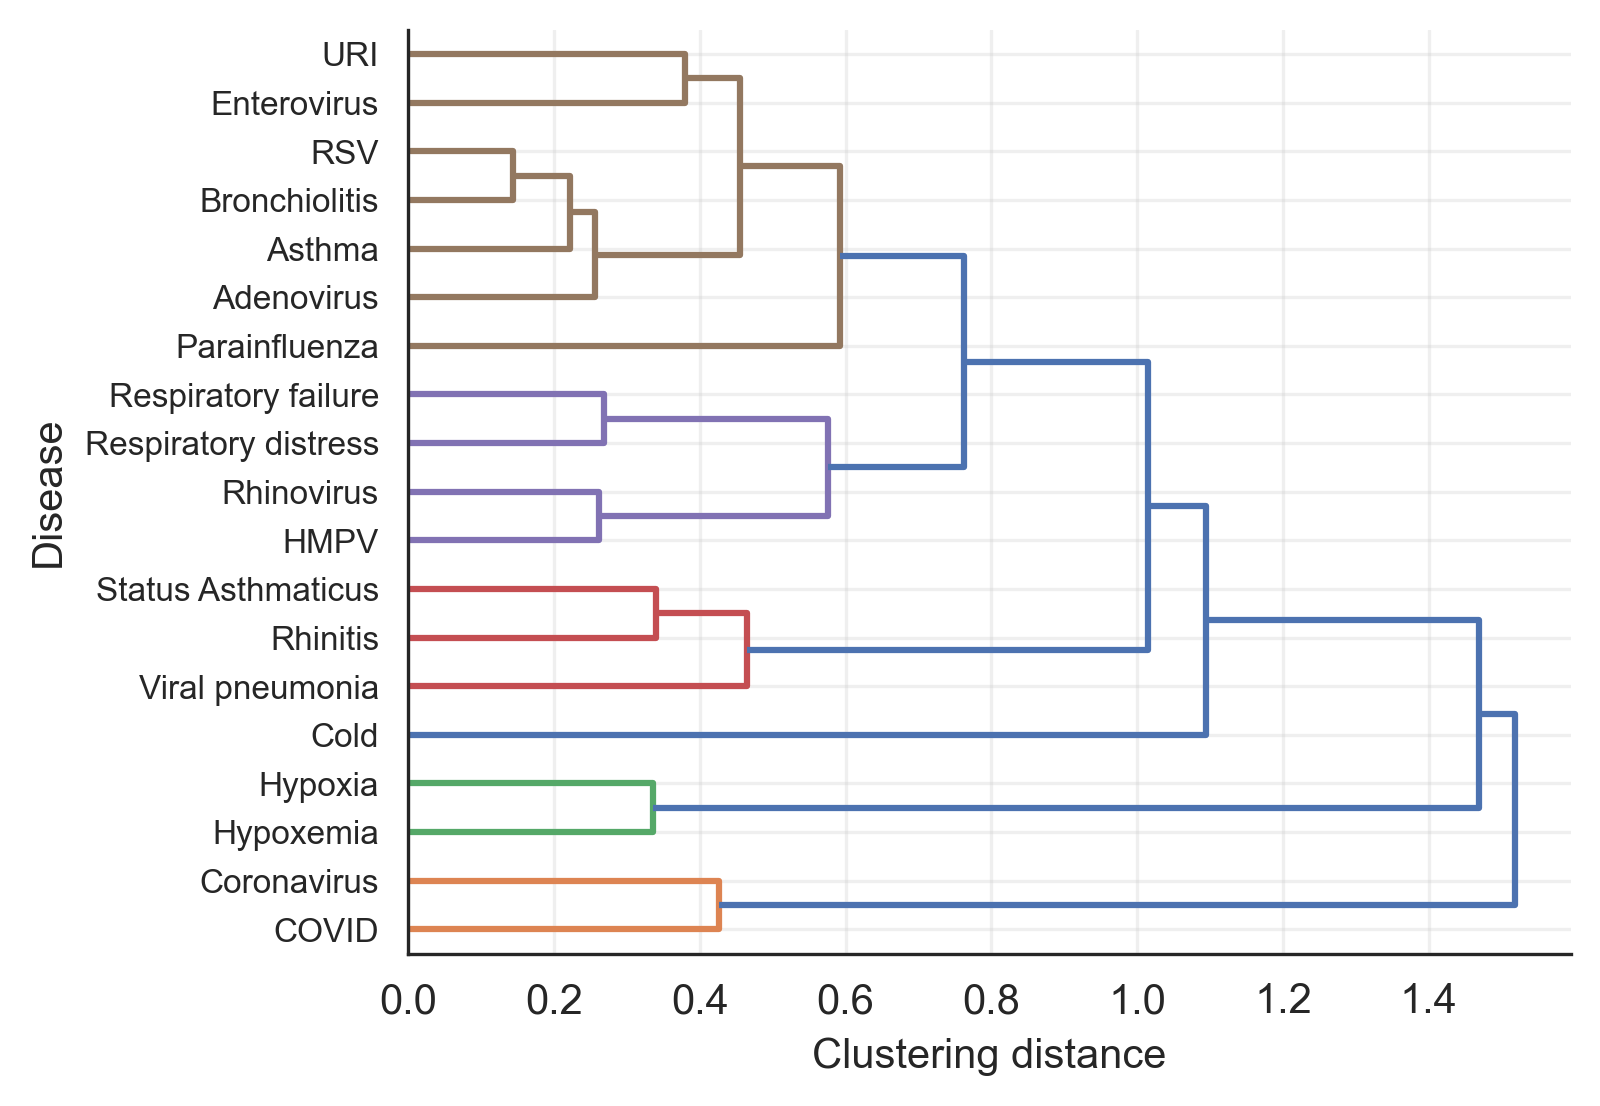

In [42]:
from scipy.cluster import hierarchy
sns.set_style("white")
sns.set_palette("deep")
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=300)
clusters = hierarchy.linkage(result[2], method="ward")
dendrogram = hierarchy.dendrogram(clusters, labels=['Adenovirus', 'Asthma', 'Bronchiolitis', 'COVID', 'Cold', 'Coronavirus',
       'Enterovirus', 'HMPV', 'Hypoxemia', 'Hypoxia', 'Parainfluenza', 'RSV',
       'Respiratory distress', 'Respiratory failure', 'Rhinitis', 'Rhinovirus',
       'Status Asthmaticus', 'URI', 'Viral pneumonia'], orientation="right", color_threshold=0.6)
# plt.axhline(150, color='red', linestyle='--') 
# plt.axhline(100, color='crimson')
ax.grid(alpha=.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=8)
plt.xlabel("Clustering distance", fontsize=10)
plt.ylabel("Disease", fontsize=10)
plt.savefig("../fig/dendrogram.png", bbox_inches='tight', dpi=300)
print ()

### dump bron and weeks and disease embedding for prediction

In [28]:
# dump the weekly 19 disease data (2334, 264, 19)
pickle.dump(bron, open(os.path.join(data_path, "bron.pkl"), 'wb'))

# dump the weeks (264, )
pickle.dump(weeks, open(os.path.join(data_path, "weeks.pkl"), 'wb'))

# normalize the patterns and let each disease sum up to 1
disease_tensor_emb = result[2] / result[2].sum(1).reshape(-1, 1)
pickle.dump(disease_tensor_emb, open(os.path.join(data_path, "disease_tensor_emb.pkl"), "wb"))